In [14]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from polygon import RESTClient
import json
import time
from sklearn.linear_model import LinearRegression
#from multiprocessing import Process, Queue, Pool, get_context
import ray
from ray.util.multiprocessing import Pool
import os
import boto3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
# Function to get data for a single ticker
def getTickerDailyDataSLOW(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print(f'Starting data pull for {ticker}...')
    data = []
    date_range = pd.date_range(start, end, freq='B')

    for business_day in date_range:
        try:
            response = client.stocks_equities_daily_open_close(symbol=ticker, date=str(business_day)[0:10])
            data.append([pd.to_datetime(response.from_) ,response.open, response.close, response.high, response.low, ticker])
        except:
            continue
    print(f'Ended data pull for {ticker}...')
    print(data)
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])

def get_ticker_data(args):
    client, ticker, date = args
    try:
        response = client.stocks_equities_daily_open_close(symbol=ticker, date=str(date)[0:10])
        return [pd.to_datetime(response.from_), response.open, response.close, response.high, response.low, ticker]
    except:
        return None

def get_ticker_daily_data_fast(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print(f'Starting data pull for {ticker}...')
    data = []
    date_range = pd.date_range(start, end, freq='B')
    input_data = [(client, ticker, x) for x in date_range]
    pool = Pool()
   
    # Use map() to parallelize the function calls
    p = get_context("fork").Pool(8)
    results = p.map(get_ticker_data, input_data)
    p.close()

    # Collect the results and remove any None values
    data = [result for result in results if result is not None]

    print(f'Ended data pull for {ticker}...')
  
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])

# Function that takes in two values from the ticker data and plots them
def createPlot(xvalue, yvalue, xlabel, ylabel, title, xvalue2=np.empty(0), yvalue2=np.empty(0)):
    fig, ax = plt.subplots()
    ax.plot(xvalue, yvalue)
    if xvalue2.size > 0:
        ax.plot(xvalue2, yvalue2)

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
   
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.grid()
    fig.tight_layout()
    plt.show()
    

def get_ticker_daily_data_ray(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print(f'Starting data pull for {ticker}...')
    data = []
    date_range = pd.date_range(start, end, freq='B')
    input_data = [(client, ticker, x) for x in date_range]

 
    # Use map() to parallelize the function calls
    with Pool() as pool:
         results = pool.map(get_ticker_data, input_data) 
  
    # Collect the results and remove any None values
    data = [result for result in results if result is not None]

    print(f'Ended data pull for {ticker}...')
  
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])

In [7]:
# Get data from start_date to end_date for the ticker
client = RESTClient(auth_key="JeeOjlOPBe5aTiQ_Jb39raRqlam45uAO")


In [21]:
def write_csv_s3(data, bucket, file_name):
    s3 = boto3.client('s3')
    data.to_csv(file_name)
    
    with open(file_name, "rb") as f:
        s3.upload_fileobj(f, bucket, file_name)
    os.remove(file_name)
    print('done')
    return 
    

In [31]:
def read_csv_s3(bucket, file_name):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=file_name)
    df = pd.read_csv(response['Body'])
    return df

In [30]:
test = read_csv_s3('twig-stockdata', "ezpw_daily_stock_prices.csv")

In [10]:
stock_data = get_ticker_daily_data_ray(client, ticker="SONY", start="2018-01-01", end="2023-02-01")

Starting data pull for SONY...


2023-04-28 21:04:10,957	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265


Ended data pull for SONY...


In [22]:
write_csv_s3(stock_data, 'twig-stockdata', 'sony_daily_stock_prices.csv')

done


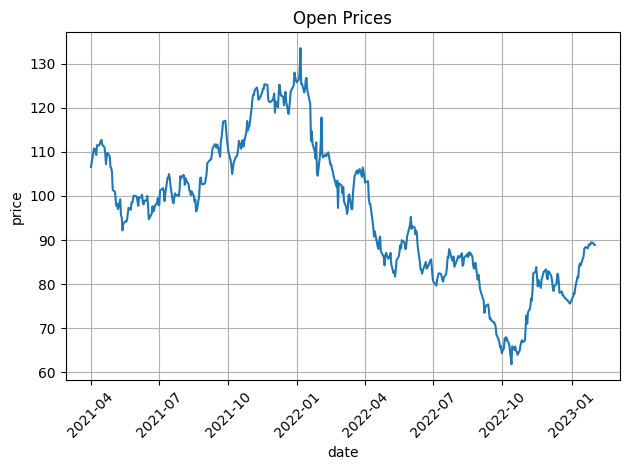

In [11]:
# Plot our Open proces from 2018-01-01 to 2023-02-01

createPlot(xvalue=stock_data.date.values, yvalue=stock_data.open.values, xlabel="date", ylabel="price", title="Open Prices")

 Build Model

Our first model, will be a SA-ARISMA model using only the series itself, predicting one day in advance then incorporating that data into its next daily prediction. Seasonally Adjusted, Autoregressive, Integrated, Simple moving average model. 

In [8]:
# Get a sample of our opening prices

stock_data_open = stock_data[['date', 'open', 'ticker']]
stock_data_open.head()

,date,open,ticker
0,2018-04-30,13.350,EZPW
1,2018-05-01,13.650,EZPW
2,2018-05-02,13.750,EZPW
3,2018-05-03,13.700,EZPW
4,2018-05-04,14.650,EZPW


In [9]:
# Creating our parameters for our model

stock_data_open["ar1"] = stock_data_open['open'].shift(1)
stock_data_open["ar2"] = stock_data_open['open'].shift(2)
stock_data_open["ar3"] = stock_data_open['open'].shift(3)
stock_data_open["ar4"] = stock_data_open['open'].shift(4)
stock_data_open["SMA"] = stock_data_open['ar1'].rolling(5).mean()
stock_data_open["int"] = stock_data_open.ar1 - stock_data_open.ar2
stock_data_open['intercept'] = np.ones(len(stock_data_open))

stock_data_open.head()

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_30097/2909731127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_open["ar1"] = stock_data_open['open'].shift(1)
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_30097/2909731127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_open["ar2"] = stock_data_open['open'].shift(2)


,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
0,2018-04-30,13.350,EZPW,NaN,NaN,NaN,NaN,NaN,NaN,1.000
1,2018-05-01,13.650,EZPW,13.350,NaN,NaN,NaN,NaN,NaN,1.000
2,2018-05-02,13.750,EZPW,13.650,13.350,NaN,NaN,NaN,0.300,1.000
3,2018-05-03,13.700,EZPW,13.750,13.650,13.350,NaN,NaN,0.100,1.000
4,2018-05-04,14.650,EZPW,13.700,13.750,13.650,13.350,NaN,-0.050,1.000


In [132]:
# Checking the shape of our data

stock_data_open.shape

(1200, 10)

In [135]:
# We removed the first 5 indexes in the data set due to Null values in the paraments

train_data = stock_data_open[5:500]
train_data.head()

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
5,2018-05-04,288200.000,BRK.A,289171.000,291850.000,291150.000,296900.000,292984.200,-2679.000,1.000
6,2018-05-07,294720.000,BRK.A,288200.000,289171.000,291850.000,291150.000,291454.200,-971.000,1.000
7,2018-05-08,295560.000,BRK.A,294720.000,288200.000,289171.000,291850.000,291018.200,6520.000,1.000
8,2018-05-09,295000.050,BRK.A,295560.000,294720.000,288200.000,289171.000,291900.200,840.000,1.000
9,2018-05-10,300140.020,BRK.A,295000.050,295560.000,294720.000,288200.000,292530.210,-559.950,1.000


In [138]:
# Using Linear Regression function to fit our model
reg = LinearRegression()
fit_model = reg.fit(train_data[['ar1','ar2','SMA']], train_data[['open']])

In [140]:
#the_sauce
fit_model.coef_

array([[ 0.92078032,  0.14386555, -0.09103138]])

In [141]:
fit_model.intercept_

array([8167.09355144])

In [122]:
fit_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [142]:
# Added our insample prediction for each day to our training data set

train_data['prediction_insample'] = fit_model.predict(train_data[['ar1','ar2','SMA','open']])
train_data.head()

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- open
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 4 features, but LinearRegression is expecting 3 features as input.

In [125]:
# Adding our error, squared error and absolute error to our training data set

train_data['error'] = train_data.open - train_data.prediction_insample
train_data['sq_error'] = train_data['error']**2
train_data['abs_error'] = np.abs(train_data['error'])

train_data

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_insample,error,sq_error,abs_error
5,2018-05-04,14.650,EZPW,13.700,13.750,13.650,13.350,13.530,-0.050,1.000,14.650,0.000,0.000,0.000
6,2018-05-07,14.800,EZPW,14.650,13.700,13.750,13.650,13.820,0.950,1.000,14.800,0.000,0.000,0.000
7,2018-05-08,14.750,EZPW,14.800,14.650,13.700,13.750,14.110,0.150,1.000,14.750,0.000,0.000,0.000
8,2018-05-09,14.150,EZPW,14.750,14.800,14.650,13.700,14.330,-0.050,1.000,14.150,0.000,0.000,0.000
9,2018-05-10,13.150,EZPW,14.150,14.750,14.800,14.650,14.410,-0.600,1.000,13.150,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020-04-16,4.820,EZPW,4.680,4.870,5.151,4.810,4.790,-0.190,1.000,4.820,-0.000,0.000,0.000
496,2020-04-17,5.000,EZPW,4.820,4.680,4.870,5.151,4.866,0.140,1.000,5.000,-0.000,0.000,0.000
497,2020-04-20,4.830,EZPW,5.000,4.820,4.680,4.870,4.904,0.180,1.000,4.830,-0.000,0.000,0.000
498,2020-04-21,4.760,EZPW,4.830,5.000,4.820,4.680,4.840,-0.170,1.000,4.760,-0.000,0.000,0.000


In [126]:
# Returns the mean for error, squared error and absolute error for the training set

train_data[['error', 'sq_error', 'abs_error']].mean()

error       0.000
sq_error    0.000
abs_error   0.000
dtype: float64

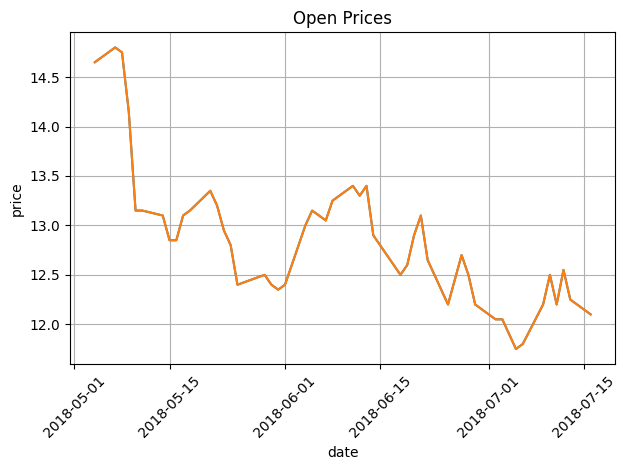

In [127]:
# Ploting our Model verses the training data

train_data_date_values = train_data.date.values[:50]
train_data_open_values = train_data.open.values[:50]
train_data_date_values = train_data.date.values[:50]
train_data_prediction_insample_values = train_data.prediction_insample.values[:50]


createPlot(xvalue=train_data_date_values, 
           yvalue=train_data_open_values, 
           xlabel='date', 
           ylabel='price', 
           title="Open Prices",
           xvalue2=train_data_date_values,
           yvalue2=train_data_prediction_insample_values
           )

In [99]:
# Creating our test data set

test_data = stock_data_open[500:]
test_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
500,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000
501,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000
502,2020-04-27,5.180,EZPW,4.920,4.720,4.900,4.760,4.826,0.200,1.000
503,2020-04-28,5.210,EZPW,5.180,4.920,4.720,4.900,4.896,0.260,1.000
504,2020-04-29,5.500,EZPW,5.210,5.180,4.920,4.720,4.986,0.030,1.000
...,...,...,...,...,...,...,...,...,...,...
1195,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000
1196,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000
1197,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000
1198,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000


In [86]:
# Fiting our model to the test data set and dadding our predictions to the test data set

test_data['prediction_oos'] = fit_model.predict(test_data[['ar1']])

test_data.head()

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos
500,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.902
501,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.723
502,2020-04-27,5.180,EZPW,4.920,4.720,4.900,4.760,4.826,0.200,1.000,4.922
503,2020-04-28,5.210,EZPW,5.180,4.920,4.720,4.900,4.896,0.260,1.000,5.180
504,2020-04-29,5.500,EZPW,5.210,5.180,4.920,4.720,4.986,0.030,1.000,5.210


In [88]:
# Adding our error, squared error and absolute error to our test data set

test_data['error'] = test_data.open - test_data.prediction_oos
test_data['sq_error'] = test_data['error']**2
test_data['abs_error'] = np.abs(test_data['error'])

test_data

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos,error,sq_error,abs_error
500,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.902,-0.182,0.033,0.182
501,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.723,0.197,0.039,0.197
502,2020-04-27,5.180,EZPW,4.920,4.720,4.900,4.760,4.826,0.200,1.000,4.922,0.258,0.067,0.258
503,2020-04-28,5.210,EZPW,5.180,4.920,4.720,4.900,4.896,0.260,1.000,5.180,0.030,0.001,0.030
504,2020-04-29,5.500,EZPW,5.210,5.180,4.920,4.720,4.986,0.030,1.000,5.210,0.290,0.084,0.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000,9.071,0.229,0.053,0.229
1196,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000,9.280,-0.210,0.044,0.210
1197,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000,9.051,-0.021,0.000,0.021
1198,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000,9.011,-0.151,0.023,0.151


In [89]:
test_data[['error', 'sq_error', 'abs_error']].mean()

error       0.013
sq_error    0.034
abs_error   0.136
dtype: float64

In [43]:
# Returns the mean for error, squared error and absolute error for the training set

test_data[['error', 'sq_error', 'abs_error']].mean()

error       0.013
sq_error    0.034
abs_error   0.136
dtype: float64

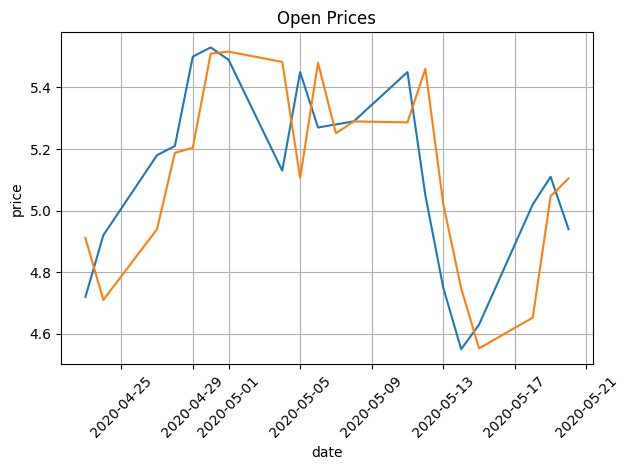

In [74]:
# Ploting our Model verses the test data

test_data_date_values = test_data.date.values[:20]
test_data_open_values = test_data.open.values[:20]
test_data_date_values = test_data.date.values[:20]
test_data_prediction_oos_values = test_data.prediction_oos.values[:20]


createPlot(xvalue=test_data_date_values, 
           yvalue=test_data_open_values, 
           xlabel='date', 
           ylabel='price', 
           title="Open Prices",
           xvalue2=test_data_date_values,
           yvalue2=test_data_prediction_oos_values
           )

In [116]:
fit_model2 = reg.fit(test_data[['ar1','ar2', 'SMA', 'int']], test_data[['open']])

In [117]:
test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/832968439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])


In [118]:
test_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos,error,sq_error,abs_error,prediction_inSample
500,2020-04-22,4.900,EZPW,4.760,4.830,5.000,4.820,4.818,-0.070,1.000,4.758,0.142,0.020,0.142,4.782
501,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.912,-0.192,0.037,0.192,4.918
502,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.710,0.210,0.044,0.210,4.743
503,2020-04-27,5.180,EZPW,4.920,4.720,4.900,4.760,4.826,0.200,1.000,4.935,0.245,0.060,0.245,4.938
504,2020-04-28,5.210,EZPW,5.180,4.920,4.720,4.900,4.896,0.260,1.000,5.191,0.019,0.000,0.019,5.195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000,9.056,0.244,0.060,0.244,9.077
1197,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000,9.282,-0.212,0.045,0.212,9.283
1198,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000,9.027,0.003,0.000,0.003,9.059
1199,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000,9.011,-0.151,0.023,0.151,9.018


In [119]:
test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
test_data['in_sample_abs_error'] = np.abs(test_data['in_sample_error'])

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:3: SettingWithCopyWarning: 
A val

In [120]:
test_data[['in_sample_error', 'in_sample_sq_error', 'in_sample_abs_error']].mean()

in_sample_error       0.000
in_sample_sq_error    0.033
in_sample_abs_error   0.136
dtype: float64